# Классификация дефектов кожи

## Дипломная работа Жеманцевой Татьяны. Skillfactory.

## Задача: создание модели классификации, которая по представленной картинке кожного покрова сможет определить варианты с процентным 
## соотношением похожести данного дефекта на известное заболевание.
 
## Данные взяты с kaggle - закрытое соревнование, данные для которого взяты и отсортированы в ISIC (https://www.isic-archive.com).
## В данной работе выполнена классификация с использованием CNN и предобученой нейросети в Tensorflow - Xception.

In [1]:
#!pip install -q tensorflow==2.3
#!pip install keras_efficientnets
#!pip freeze > requirements.txt

# Импортируем библиотеки 

In [1]:
# Импортируем библиотеки

import pandas as pd # импортируем необходимые библиотеки
import numpy as np
import re
import random
import os
import sys
import PIL
import cv2

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import ExtraTreeRegressor
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 

from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import itertools 

#from catboost import CatBoostRegressor

from tqdm import tqdm
from tqdm.notebook import tqdm

from itertools import combinations
from scipy.stats import ttest_ind


# # keras
import tensorflow as tf
from tensorflow import keras
#import tensorflow.keras.layers as L
#from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#import albumentations
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
#from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
#import tensorflow as tf
import tensorflow.keras 
import tensorflow.keras.models #as M
#import tensorflow.keras.layers as L
#import tensorflow.keras.backend #as K
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay as ExpDecay

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from glob import glob
from glob import iglob
#from keras.applications import InceptionV3
#from keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense ,LeakyReLU,UpSampling2D, GlobalAveragePooling2D,Conv2DTranspose, BatchNormalization,GlobalMaxPool2D, Convolution2D

import nltk
from nltk.corpus import stopwords

# plt
import matplotlib.pyplot as plt
import seaborn as sns
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
#DATA_PATH = "/content/drive/My Drive/cars2/"
#PATH = "/content/"  # рабочая директория

In [3]:
#from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import EfficientNetB4
print(keras.__version__)
print(tf.__version__)

2.4.0
2.4.1


In [4]:
print(tf.__version__)

2.4.1


In [5]:
#from tensorflow.keras.applications import InceptionV3#
#keras.applications.EfficientNetB4()

In [6]:
print('Python       :', sys.version.split('\n')[0])
print('Numpmodel.summary()y        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.9 | packaged by conda-forge | (default, Dec  9 2020, 21:08:20) 
Numpmodel.summary()y        : 1.19.5
Tensorflow   : 2.4.1


# Задаем константы

In [2]:
train_path ='/kaggle/input/dermnet/train/'
test_path = '/kaggle/input/dermnet/test/'


In [3]:
RANDOM_SEED = 42
IMAGE_SIZE         = (299, 299)
#INPUT_SHAPE        = (224, 224, 3)
IMG_SIZE           = 299 # размер входного изображения для Xception по-умолчанию
IMG_CHANNELS       = 3   # у RGB 3 канала
input_shape        = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
# Keras settings
BATCH_SIZE = 12
VAL_BATCH_SIZE = 12
VAL_SPLIT          = 0.2 # сколько данных выделяем на тест = 15%
EPOCHS = 12
LR = 0.00001

# Предобработка изображений: просмотр, аугментация, создание обучающего и тестового наборов

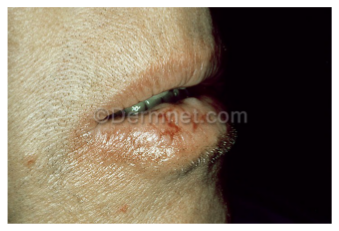

In [9]:
# Посмотрим пример картинки

img = PIL.Image.open(train_path + "Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions/actinic-cheilitis-sq-cell-lip-2.jpg") # load_img(train_path + "nevus/ISIC_0000041.jpg")  "ISIC_0000398.jpg" ../input/dermnet/train/Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions
plt.imshow(img)
plt.axis("off")
plt.show()


In [10]:
# Преобразуем картинку в массив

x = img_to_array(img)
print(x.shape)

(481, 720, 3)


In [4]:
# C помощью glob определяем сколько разных папок-классов с картинками имеется.

className = glob(train_path + '/*' )
numberOfClass = len(className)
print("NumberOfClass: ",numberOfClass)

NumberOfClass:  23


In [5]:
# C помощью glob определяем сколько разных папок-классов с картинками имеется.

className = glob(test_path + '/*' )
numberOfClass = len(className)
print("NumberOfClass: ",numberOfClass)

NumberOfClass:  23


## Аугментация с помощью ImageDataGenerator (выполняется либо этот раздел аугментации, либо следующий )

In [6]:
# Аугментация обучающего датасета
# Официальная документация: https://keras.io/preprocessing/image/

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 60,
    brightness_range = [0.5, 1.5],
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=[0.75,1.25],
    fill_mode='reflect')  #  fill_mode='nearest'

       
test_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=VAL_SPLIT)

In [7]:
# Завернем наши данные в генератор.

train_generator = train_datagen.flow_from_directory(
    train_path,      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='validation') # set as validation data


Found 12453 images belonging to 23 classes.
Found 3104 images belonging to 23 classes.


In [8]:
test_val_generator = test_datagen.flow_from_directory(
    directory=test_path,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)


Found 4002 images belonging to 23 classes.


## Аугментация с помощью albumentations (выполняется либо этот раздел аугментации, либо предыдущий)

In [13]:
!pip install albumentations

In [14]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-t5l8_ztf
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-t5l8_ztf
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29531 sha256=eeb22eba168226ed21591bf4e73f4fd390be68aef333098b7194c22f5f36d82f
  Stored in directory: /tmp/pip-ephem-wheel-cache-l3cm59g7/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor


In [15]:
#Аугментация данных важна, когда мы работаем с небольшим датасетом. Это как раз наш случай.

import albumentations
import cv2
from ImageDataAugmentor.image_data_augmentor import *
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

In [16]:
# попробовать этот вариант

AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5), #0.5
    albumentations.Rotate(limit=90),
    albumentations.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
    albumentations.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
   # albumentations.HueSaturationValue(p=0.5),
    albumentations.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.00, always_apply=False, p=0.5),
    albumentations.RandomContrast(limit=0.1, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )

      
test_datagen = ImageDataAugmentor(rescale=1./255)

val_datagen = ImageDataAugmentor(rescale=1. / 255, validation_split=VAL_SPLIT)

In [16]:
# Либо этот вариант. 


AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5), #0.5
    albumentations.Rotate(limit=20, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=IMG_SIZE, width=IMG_SIZE),
        albumentations.CenterCrop(height=IMG_SIZE, width=IMG_SIZE),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
   # albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )

      
test_datagen = ImageDataAugmentor(rescale=1./255)

val_datagen = ImageDataAugmentor(rescale=1. / 255, validation_split=VAL_SPLIT)

In [17]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    train_path,      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data



/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 12453 images belonging to 23 classes.
Found 3104 images belonging to 23 classes.


In [18]:
test_val_generator = test_datagen.flow_from_directory(
    directory=test_path,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 4002 images belonging to 23 classes.


Пример картинок из train_generator


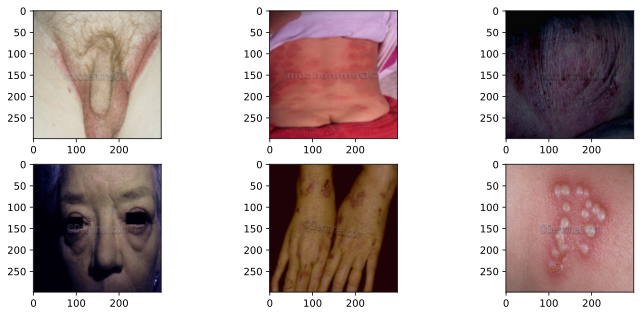

In [19]:
# Прсмотрим несколько картинок после применения аугментации.

from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
   # plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

In [20]:
imgs, labels = next(train_generator)
print(imgs.shape, labels.shape)
print(len(train_generator))

(24, 299, 299, 3) (24, 23)
519


In [21]:
imgs, labels = next(test_generator)
print(imgs.shape, labels.shape)
print(len(test_generator))

(24, 299, 299, 3) (24, 23)
130


# Посмотрим распределение данных по классам.

In [22]:

def classes_count (path):
    # определяет содержимое папок классов
    
    classes = []
    for filename in iglob(os.path.join(path, "**","*.jpg")):
        classes.append(os.path.split(os.path.split(filename)[0])[-1])
    cnt = Counter(classes)
    return cnt

def percentage_value(pct, allvals):
    # вычисляет процентное значение размера класса
    
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

def plot_dataset_description(path, title):
    # строит круговую диаграмму
    
    classes_cnt = classes_count(path)
    values = list(classes_cnt.values())
    labels = list(classes_cnt.keys())

    plt.figure(figsize=(8,8))
    plt.pie(values, labels=labels, autopct=lambda pct: percentage_value(pct, values), 
            shadow=True, startangle=140)

    plt.title(title + ' размера ' + str(sum(classes_cnt.values())))    
    plt.show()

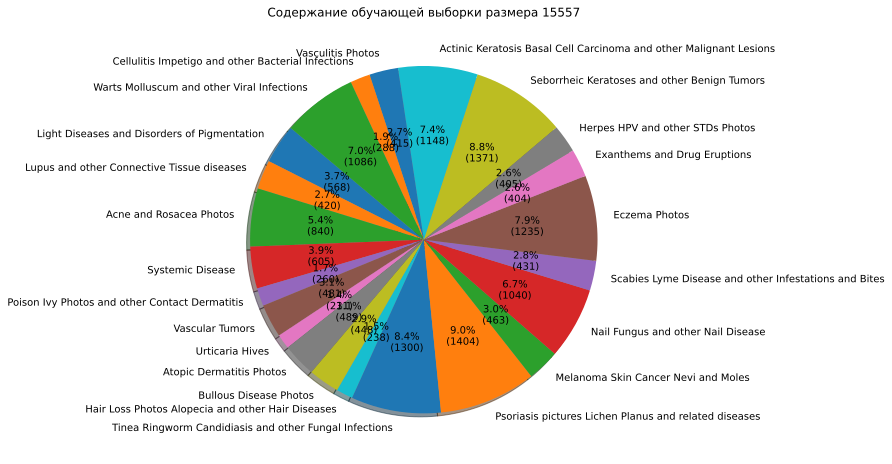

In [23]:
plot_dataset_description(os.path.join(train_path), "Содержание обучающей выборки")

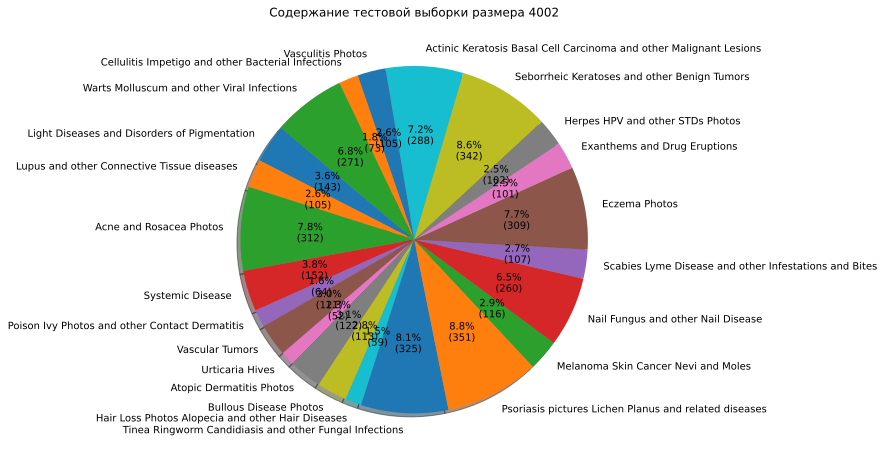

In [24]:
plot_dataset_description(os.path.join(test_path), "Содержание тестовой выборки")

In [25]:
def plot_dataset_description_bar(path, title):
    # строит диаграмму столбиками
 
    classes_val = classes_count(path)
    

    values = list(classes_val.values())
    labels = list(classes_val.keys())
    plt.figure(figsize=(10, 5))
    plt.bar(values, (values), width=10)
    plt.ylabel('Количество картинок', fontsize=10)
    plt.xticks(values, labels, fontsize=8, rotation=90)
    plt.title(title)

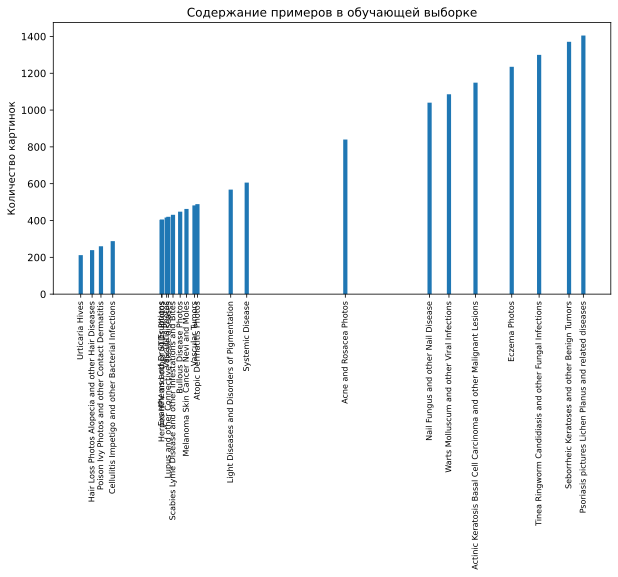

In [26]:
plot_dataset_description_bar(os.path.join(train_path), 'Содержание примеров в обучающей выборке')

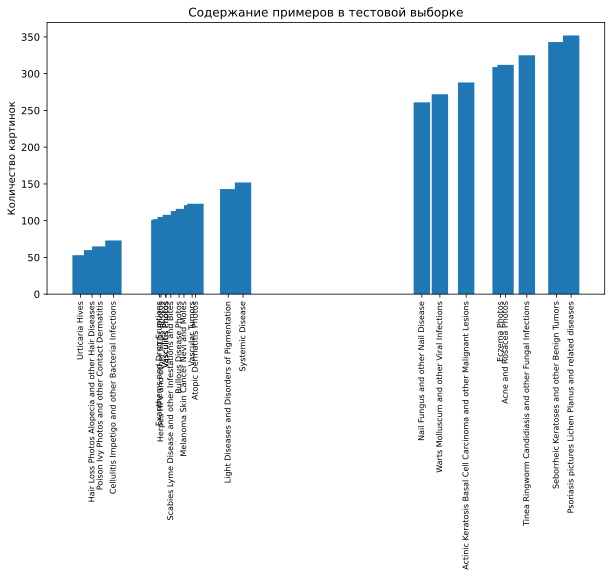

In [27]:
plot_dataset_description_bar(os.path.join(test_path), 'Содержание примеров в тестовой выборке')

# Анализ данных показывает, что наша выборка несбалансирована, поскольку самый многочисленный класс в 3 раза превышает самый маленький.
# В этом случае нам подошли бы метрики precision, recall, F1-score, учитывающие веса классов, но они используются в бинарной классификации. В работе использовалась метрика accuracy.
# Для учета дисбаланса классов для каждого класса добавлены веса в параметр class_weight при обучении,что позволило повысить точность модели.

 
# В задаче для оценки эффективности  модели в процессе обучения я использовала
# 1. accurancy - с и без использования class_weight 
# 2. Для многоклассовой выборки с несбалансированными классами на просторах интернета рекомендуют использовать метрику macro F1. Создала свои функции для подсчета loss и macro F1 - решение давало достаточно низкую степень обучаемости, от идеи отказалась. на 45 эпохе результаты: loss: 1.0659 - f1: 0.2935 - val_loss: 1.8877 - val_f1: 0.1625
# Также попробовала оптимизацию по созданной функции потерь F1_loss - на 40й эпохе результат F1 = 0.23.

# 3. Оптимизировала модель по loss - категориальная кросс энтропия. 



# Построение и обучение модели.

In [ ]:
#model = keras.models.load_model('/kaggle/input/inputmod/best_model_step1.hdf5')

## Вынесем функции для раздела построения и обучения модели.

In [32]:
def info_layers():
    # вывод информации по слоям модели в процессе тюнинга
    
    print("Number of layers in the model:", len(model.layers))
    print("Number of trainable_variables layers in the model:", len(model.trainable_variables))
    print("Number of layers in the base model: ", len(base_model.layers))
    print("Number of variables layers in the base model: ", len(base_model.trainable_variables))
    print("Layers in the model:")
    for layer in model.layers:
        print(layer, layer.trainable)

def graph(history):
    # построние графиков изменения метрики и функции потерь в процессе обучения по эпохам
    
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], 'b*-', label="training acc")
    plt.plot(history.history['val_accuracy'], 'r*-', label="validation acc")
    plt.grid()
    plt.title("train_acc vs val_acc")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], 'b*-', label="training loss")
    plt.plot(history.history['val_loss'], 'r*-', label="validation loss")
    plt.grid()
    plt.title("Training and validation loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    
    


In [ ]:
# Создадим собственную метрику f1 и функцию потерь - f1_loss

from keras import backend as K

def f1(y_true, y_pred):
    # метрика macro F1
    
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    # функция потерь
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [33]:
# CallBack для сохранения модели, ее весов и лучшей модели, изменения LR в случае отсутствия прогресса обучения, и остановка обучения

weightpath = "best_model.hdf5"
checkpoint = ModelCheckpoint(weightpath , monitor = 'val_accuracy' , mode = 'max', verbose = 1,save_best_only=True) #save_weights_only=True
reducer = ReduceLROnPlateau(monitor='loss', patience= 3,factor=0.2, min_lr=0.00000001,  verbose = 1, cooldown=2, mode='min',min_delta=0.0000001) #min_delta=0.000000001
early_stop= EarlyStopping(monitor='loss',patience= 10, mode='min')  #min_delta=0.000000001


In [34]:
callbacks_list = [checkpoint, reducer, early_stop] 

In [35]:
# Выведем классы для удобства проставления весов

classes = {v: k for k, v in train_generator.class_indices.items()}
print(classes)

{0: 'Acne and Rosacea Photos', 1: 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 2: 'Atopic Dermatitis Photos', 3: 'Bullous Disease Photos', 4: 'Cellulitis Impetigo and other Bacterial Infections', 5: 'Eczema Photos', 6: 'Exanthems and Drug Eruptions', 7: 'Hair Loss Photos Alopecia and other Hair Diseases', 8: 'Herpes HPV and other STDs Photos', 9: 'Light Diseases and Disorders of Pigmentation', 10: 'Lupus and other Connective Tissue diseases', 11: 'Melanoma Skin Cancer Nevi and Moles', 12: 'Nail Fungus and other Nail Disease', 13: 'Poison Ivy Photos and other Contact Dermatitis', 14: 'Psoriasis pictures Lichen Planus and related diseases', 15: 'Scabies Lyme Disease and other Infestations and Bites', 16: 'Seborrheic Keratoses and other Benign Tumors', 17: 'Systemic Disease', 18: 'Tinea Ringworm Candidiasis and other Fungal Infections', 19: 'Urticaria Hives', 20: 'Vascular Tumors', 21: 'Vasculitis Photos', 22: 'Warts Molluscum and other Viral Infections'}


In [36]:
# Установим вес "2"и "3" для классов, размер которых в 2-3 раза меньше самых больших классов, сделав эти классы в 2-3 раза важнее

class_weight = {0: 1., 1: 0.6, 2: 1., 3: 1., 4: 1., 5: 0.6, 6: 1., 7: 1., 8: 1.,9: 1., 10: 1., 11: 1., 12: 0.6, 13: 1., 14: 0.6, 15: 1., 16: 0.6, 17: 1.,18: 0.6, 19: 1., 20: 1., 21: 1., 22: 1.}

## Шаг1  Сформируем модель

In [ ]:
# В процессе обучения проводились опыты с разными моделями, в качестве base_model необходимо выбрать  Xception, 
# как показавшую лучшие результаты

#base_model2 = EfficientNetB4(weights='imagenet', include_top=False, input_shape=input_shape)

In [25]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

83689472/83683744 [==============================] - 1s 0us/step


In [25]:
# Установим все слои base_model в неактивное состояние

base_model.trainable = False

In [26]:
# CNN модель (вариант 1)

model=Sequential()
##model.add(base_model)

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
print('ок')
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
#model.add(L.Dense(512,activation='relu'))
#model.add(L.BatchNormalization())
model.add(Dense(numberOfClass, activation='softmax'))

ок


In [ ]:
# CNN модель с добавлением Xception, которая показала наилучший результат 

model = Sequential()
 
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(numberOfClass, activation='softmax'))

In [27]:
# Посмотрим информацию о количестве слоев модели и модели Imagenet

info_layers()

Number of layers in the model: 14
Number of trainable_variables layers in the model: 12
Number of layers in the base model:  132
Number of variables layers in the base model:  0
Layers in the model:
<tensorflow.python.keras.engine.functional.Functional object at 0x7f96b4ca6090> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f96b4c91450> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f96b4b2a0d0> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f96b4ab3690> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f96b4abc890> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f96b4b23110> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f96b4c856d0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f96b4ac4490> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f96b4ac4810> True
<tensorflow.python.keras.layers

In [45]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 102

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [47]:
# Посмотрим структуру модели

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 64)        1179712   
_________________________________________________________________
batch_normalization_6 (Batch (None, 10, 10, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 10, 10, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 5, 256)        

In [ ]:
# Посмотрим на схему модели.

from keras.utils import plot_model
plot_model(model,show_shapes=True,show_layer_names=True)

In [28]:
# Компилируем модель

LR=0.0008
model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=optimizers.Adam(LR),loss=f1_loss, metrics=f1)
#model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=f1)

In [30]:
%%time
history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs= 15, #EPOCHS,
        class_weight=class_weight,
        validation_data=test_generator,
        validation_steps=len(test_generator),
        callbacks = callbacks_list)

Epoch 1/15
519/519 [==============================] - 334s 633ms/step - loss: 2.3826 - accuracy: 0.1859 - val_loss: 2.6732 - val_accuracy: 0.2252

Epoch 00001: val_accuracy improved from -inf to 0.22519, saving model to best_model.hdf5
Epoch 2/15
519/519 [==============================] - 194s 374ms/step - loss: 2.0198 - accuracy: 0.2747 - val_loss: 2.7149 - val_accuracy: 0.2194

Epoch 00002: val_accuracy did not improve from 0.22519
Epoch 3/15
519/519 [==============================] - 195s 375ms/step - loss: 1.9481 - accuracy: 0.3006 - val_loss: 2.6563 - val_accuracy: 0.2423

Epoch 00003: val_accuracy improved from 0.22519 to 0.24227, saving model to best_model.hdf5
Epoch 4/15
519/519 [==============================] - 203s 391ms/step - loss: 1.8475 - accuracy: 0.3287 - val_loss: 2.7156 - val_accuracy: 0.2413

Epoch 00004: val_accuracy did not improve from 0.24227
Epoch 5/15
519/519 [==============================] - 205s 395ms/step - loss: 1.8000 - accuracy: 0.3460 - val_loss: 2.644

In [31]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)

model.save('model_last_11v1_23.hdf5')
model.load_weights('best_model.hdf5')

In [10]:
#model = keras.models.load_model('model_last_11v9_23.hdf5')

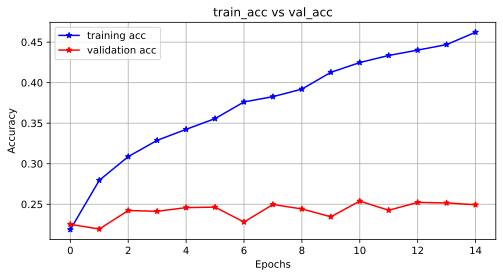

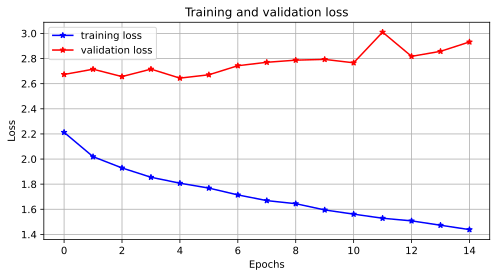

In [32]:
graph(history)

# Шаг2 Изменим количество неактивных слоев в сети imagenet и дообучим модель

In [38]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 75

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [39]:
# Посмотрим информацию о количестве слоев модели 

info_layers()

Number of layers in the model: 14
Number of trainable_variables layers in the model: 79
Number of layers in the base model:  132
Number of variables layers in the base model:  67
Layers in the model:
<tensorflow.python.keras.engine.functional.Functional object at 0x7f96b4ca6090> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f96b4c91450> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f96b4b2a0d0> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f96b4ab3690> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f96b4abc890> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f96b4b23110> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f96b4c856d0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f96b4ac4490> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f96b4ac4810> True
<tensorflow.python.keras.layers

In [40]:
# Посмотрим структуру модели

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        1179712   
_________________________________________________________________
batch_normalization_4 (Batch (None, 10, 10, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 10, 10, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 256)         1

In [41]:
# Компилируем модель

LR=0.0006
model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=['accuracy'])


In [42]:
%%time
history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator), #train_generator.samples, # train_generator.samples # len(train_generator)
        epochs= 15, #EPOCHS,
        class_weight=class_weight,
        validation_data=test_generator,
        validation_steps=len(test_generator), #test_generator.samples,  # test_generator.samples
        callbacks = callbacks_list)

Epoch 1/15
519/519 [==============================] - 216s 411ms/step - loss: 1.9588 - accuracy: 0.3077 - val_loss: 2.5874 - val_accuracy: 0.2519

Epoch 00001: val_accuracy did not improve from 0.25387
Epoch 2/15
519/519 [==============================] - 213s 410ms/step - loss: 1.6696 - accuracy: 0.3990 - val_loss: 2.5859 - val_accuracy: 0.2829

Epoch 00002: val_accuracy improved from 0.25387 to 0.28286, saving model to best_model.hdf5
Epoch 3/15
519/519 [==============================] - 212s 409ms/step - loss: 1.5020 - accuracy: 0.4524 - val_loss: 2.8606 - val_accuracy: 0.2787

Epoch 00003: val_accuracy did not improve from 0.28286
Epoch 4/15
519/519 [==============================] - 212s 409ms/step - loss: 1.3961 - accuracy: 0.4921 - val_loss: 2.7034 - val_accuracy: 0.2790

Epoch 00004: val_accuracy did not improve from 0.28286
Epoch 5/15
519/519 [==============================] - 212s 408ms/step - loss: 1.2551 - accuracy: 0.5437 - val_loss: 2.7864 - val_accuracy: 0.2771

Epoch 00

In [43]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)

model.save('model_last_11v2.hdf5')
model.load_weights('best_model.hdf5')

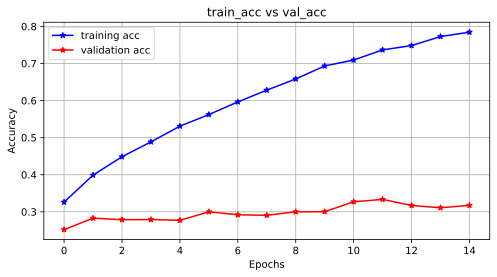

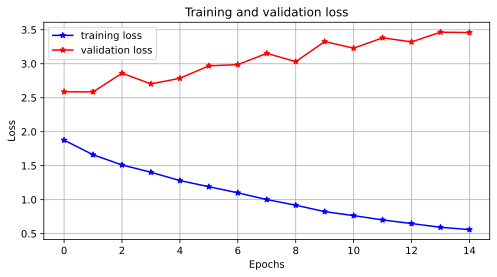

In [44]:
graph(history)

In [11]:
# Шаг3
#model = keras.models.load_model('/kaggle/input/tttttt/model_last_11v8_23.hdf5')

In [ ]:
# Шаг3 Снова изменим количество неактивных слоев в сети imagenet и дообучим модель

In [26]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 31

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


In [29]:
# Посмотрим информацию о количестве слоев модели 

info_layers()

NameError: name 'info_layers' is not defined

In [28]:
# Посмотрим структуру модели

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        1179712   
_________________________________________________________________
batch_normalization_4 (Batch (None, 10, 10, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 10, 10, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 256)         1

In [30]:
# Компилируем модель

LR=0.0004
model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
%%time
history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator), #train_generator.samples, # train_generator.samples # len(train_generator)
        epochs= 9, #EPOCHS,
        class_weight=class_weight,
        validation_data=test_generator,
        validation_steps=len(test_generator), #test_generator.samples,  # test_generator.samples
        callbacks = callbacks_list)

Epoch 1/9
519/519 [==============================] - 512s 980ms/step - loss: 0.6559 - accuracy: 0.7515 - val_loss: 3.4770 - val_accuracy: 0.3251

Epoch 00001: val_accuracy improved from -inf to 0.32506, saving model to best_model.hdf5
Epoch 2/9
519/519 [==============================] - 380s 731ms/step - loss: 0.5107 - accuracy: 0.7998 - val_loss: 3.7940 - val_accuracy: 0.3331

Epoch 00002: val_accuracy improved from 0.32506 to 0.33312, saving model to best_model.hdf5
Epoch 3/9
519/519 [==============================] - 378s 727ms/step - loss: 0.4390 - accuracy: 0.8279 - val_loss: 3.9345 - val_accuracy: 0.3392

Epoch 00003: val_accuracy improved from 0.33312 to 0.33924, saving model to best_model.hdf5
Epoch 4/9
519/519 [==============================] - 376s 722ms/step - loss: 0.4201 - accuracy: 0.8267 - val_loss: 3.7852 - val_accuracy: 0.3589

Epoch 00004: val_accuracy improved from 0.33924 to 0.35889, saving model to best_model.hdf5
Epoch 5/9
519/519 [==============================] 

In [38]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)

model.save('model_last_11v4_23.hdf5')
model.load_weights('best_model.hdf5')

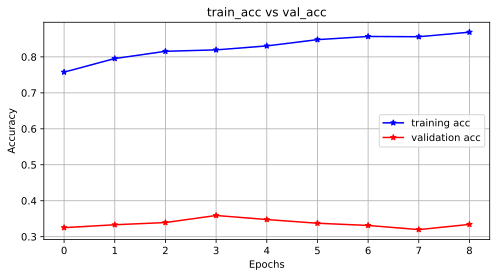

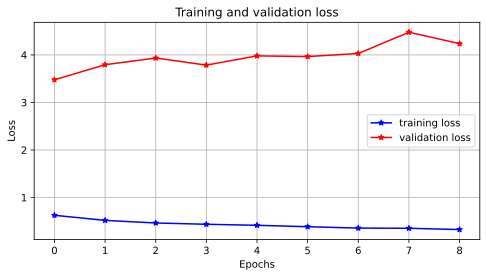

In [39]:
graph(history)

In [ ]:
# Шаг4

In [75]:
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 1

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False


In [76]:
# Посмотрим информацию о количестве слоев модели 

info_layers()

Number of layers in the model: 14
Number of trainable_variables layers in the model: 79
Number of layers in the base model:  132
Number of variables layers in the base model:  154
Layers in the model:
<tensorflow.python.keras.engine.functional.Functional object at 0x7f9ec1b74fd0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9ec004cad0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f9ec0053150> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f9ec00baa90> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9ec005abd0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9ec00555d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9ec00634d0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f9ec006df10> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f9ec007cf50> True
<tensorflow.python.keras.layer

In [77]:
# Посмотрим структуру модели

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        1179712   
_________________________________________________________________
batch_normalization_4 (Batch (None, 10, 10, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 10, 10, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 256)         1

In [136]:
# Компилируем модель

LR=0.000002
model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=['accuracy'])

In [137]:
%%time
history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator), #train_generator.samples, # train_generator.samples # len(train_generator)
        epochs= 2, #EPOCHS,
        class_weight=class_weight,
        validation_data=test_generator,
        validation_steps=len(test_generator), #test_generator.samples,  # test_generator.samples
        callbacks = callbacks_list)

Epoch 1/2
1038/1038 [==============================] - 396s 378ms/step - loss: 0.2441 - accuracy: 0.8951 - val_loss: 4.5287 - val_accuracy: 0.3595

Epoch 00001: val_accuracy did not improve from 0.36115
Epoch 2/2
1038/1038 [==============================] - 384s 370ms/step - loss: 0.2472 - accuracy: 0.8928 - val_loss: 4.5464 - val_accuracy: 0.3618

Epoch 00002: val_accuracy improved from 0.36115 to 0.36179, saving model to best_model.hdf5
CPU times: user 14min 37s, sys: 21.2 s, total: 14min 58s
Wall time: 13min


In [138]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)

model.save('model_last_11v9_23.hdf5')
model.load_weights('best_model.hdf5')

In [154]:
# Сохраним модель для прототипа 

# serialize to JSON
json_file = model.to_json()
with open('fileq.json', "w") as file:
    file.write(json_file)
# serialize weights to HDF5
model.save_weights('best.hdf5')

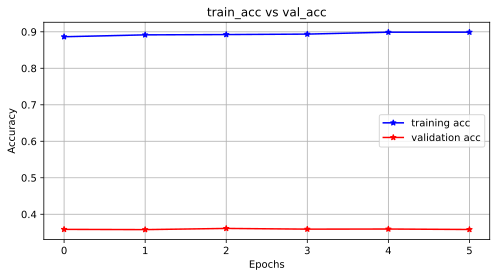

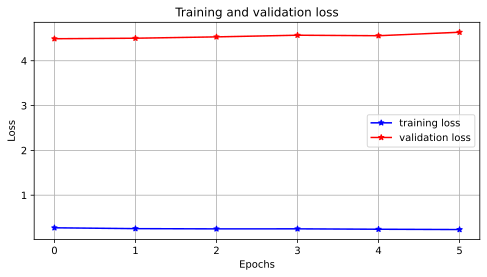

In [125]:
graph(history)

# Результаты

In [ ]:
# Считаем финальную точность модели по Accuracy и Loss

score_loss, score_acc = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("F1: %.2f%%" % (score_acc*100))
print("Loss: %.2f%%" % (score_loss))

## Confugn matrix по тестовым данным

In [19]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    # функция рисования confusion_matrix

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12,12))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=8)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

In [139]:
%%time
Y_pred1 = model.predict(test_val_generator,verbose=1)  # test_val_generator
y_pred_val = np.argmax(Y_pred1, axis=1)
y_pred_val

334/334 [==============================] - 34s 100ms/step
CPU times: user 47.4 s, sys: 773 ms, total: 48.2 s
Wall time: 34.2 s


array([20,  0, 14, ..., 22, 22, 22])

In [140]:
cnf_matrix_val = confusion_matrix(test_val_generator.classes, y_pred_val)
classes = {v: k for k, v in test_val_generator.class_indices.items()}
print(classes)

{0: 'Acne and Rosacea Photos', 1: 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 2: 'Atopic Dermatitis Photos', 3: 'Bullous Disease Photos', 4: 'Cellulitis Impetigo and other Bacterial Infections', 5: 'Eczema Photos', 6: 'Exanthems and Drug Eruptions', 7: 'Hair Loss Photos Alopecia and other Hair Diseases', 8: 'Herpes HPV and other STDs Photos', 9: 'Light Diseases and Disorders of Pigmentation', 10: 'Lupus and other Connective Tissue diseases', 11: 'Melanoma Skin Cancer Nevi and Moles', 12: 'Nail Fungus and other Nail Disease', 13: 'Poison Ivy Photos and other Contact Dermatitis', 14: 'Psoriasis pictures Lichen Planus and related diseases', 15: 'Scabies Lyme Disease and other Infestations and Bites', 16: 'Seborrheic Keratoses and other Benign Tumors', 17: 'Systemic Disease', 18: 'Tinea Ringworm Candidiasis and other Fungal Infections', 19: 'Urticaria Hives', 20: 'Vascular Tumors', 21: 'Vasculitis Photos', 22: 'Warts Molluscum and other Viral Infections'}


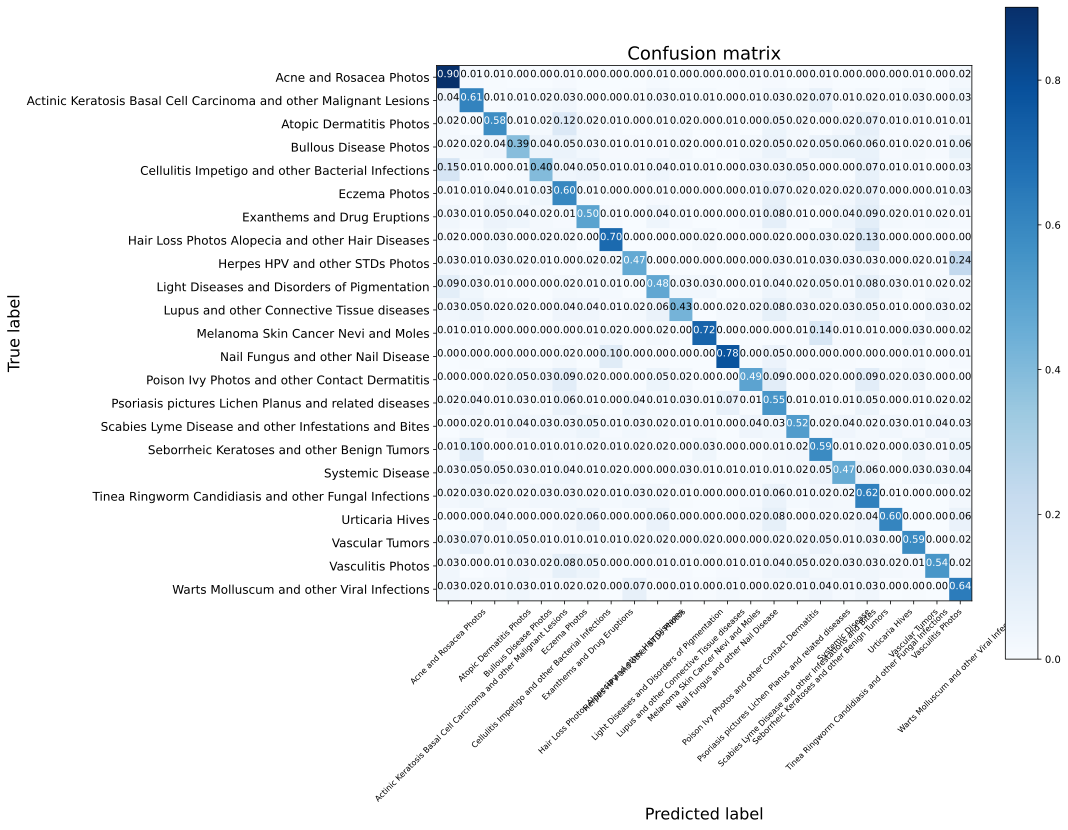

In [141]:
plot_confusion_matrix(cnf_matrix_val, list(classes.values()))

In [142]:
# классификация ответов

print(classification_report(test_val_generator.classes, y_pred_val, target_names=list(classes.values())))

                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.75      0.90      0.82       312
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.63      0.61      0.62       288
                                          Atopic Dermatitis Photos       0.54      0.58      0.56       123
                                            Bullous Disease Photos       0.40      0.39      0.40       113
                Cellulitis Impetigo and other Bacterial Infections       0.35      0.40      0.37        73
                                                     Eczema Photos       0.62      0.60      0.61       309
                                      Exanthems and Drug Eruptions       0.45      0.50      0.47       101
                 Hair Loss Photos Alopecia and other Hair Diseases       0.44      0.70      0.54        60
                           

# По матрице и по значением метрик в общем результаты неплохие
# accurancy получилась 0.6, макро F1 = 0.56 из 4002 примеров
# По классам F1 в от 46 до 82 процетов, все классы определяются.
# При наличии большого количества данных даже при 23 классах и несбалансированности результаты значительно лучше модели с 9 классами

# Tестовая демонстрация.

In [56]:
def load_image(filename):
    # загружает картинку
    
    img = cv2.imread(os.path.join(train_path, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    return img

def predict(imag):
    # возвращает первые три максимальных значений из предсказанных для каждого класса
    
    probabilities = model.predict(np.asarray([imag]))[0]
    class_idx = (-probabilities).argsort()[:3]  # np.argmax(probabilities)
    return class_idx, probabilities[class_idx]

def turn(img):
    # функция поворота изображения на 90 градусов
    
    h,w,c = img.shape
    empty_img = img
    for i in range(h):
        for j in range(w):
            empty_img[i,j] = img[h-j-1,w-i-1]
            empty_img = empty_img[0:h,0:w]
    return empty_img

In [13]:
classes = {v: k for k, v in train_generator.class_indices.items()}
print(classes)

{0: 'Acne and Rosacea Photos', 1: 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 2: 'Atopic Dermatitis Photos', 3: 'Bullous Disease Photos', 4: 'Cellulitis Impetigo and other Bacterial Infections', 5: 'Eczema Photos', 6: 'Exanthems and Drug Eruptions', 7: 'Hair Loss Photos Alopecia and other Hair Diseases', 8: 'Herpes HPV and other STDs Photos', 9: 'Light Diseases and Disorders of Pigmentation', 10: 'Lupus and other Connective Tissue diseases', 11: 'Melanoma Skin Cancer Nevi and Moles', 12: 'Nail Fungus and other Nail Disease', 13: 'Poison Ivy Photos and other Contact Dermatitis', 14: 'Psoriasis pictures Lichen Planus and related diseases', 15: 'Scabies Lyme Disease and other Infestations and Bites', 16: 'Seborrheic Keratoses and other Benign Tumors', 17: 'Systemic Disease', 18: 'Tinea Ringworm Candidiasis and other Fungal Infections', 19: 'Urticaria Hives', 20: 'Vascular Tumors', 21: 'Vasculitis Photos', 22: 'Warts Molluscum and other Viral Infections'}


Источник: class: Acne and Rosacea Photos, file: Acne and Rosacea Photos/hidradenitis-suppurativa-69.jpg
Предсказано: класс: Eczema Photos, с вероятностью: 0.362245
Предсказано: класс: Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions, с вероятностью: 0.253171
Предсказано: класс: Seborrheic Keratoses and other Benign Tumors, с вероятностью: 0.154660


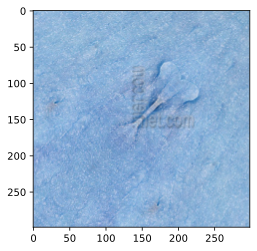

<Figure size 432x288 with 0 Axes>

Источник: class: Nail Fungus and other Nail Disease, file: Nail Fungus and other Nail Disease/lichen-planus-134.jpg


error: OpenCV(4.5.1) /tmp/pip-req-build-tk9iuyva/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [59]:
# Выберем три примера из тестового набора данных и сделаем для них предсказание

for idx, filename in enumerate(random.sample(test_generator.filenames, 3)):    # test_val_generator
    print("Источник: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    path_f = (os.path.join(train_path, filename)) #train_path + filename

    img = load_image(filename)
   
    key0=[]
    key1=[]
    key2=[]
    real_pred=[]
    values = []
    real_class =[]
    prediction = []
    
    # реализация TTA изображения: используем оригинальное изображение и повернутое два раза на 90 градусов
    
    preds =  predict(img)
    prediction.append(preds)

    turn(img)
    preds =  predict(img)
    prediction.append(preds)
    
    turn(img)
    preds =  predict(img)
    prediction.append(preds)
    
    for key,value in prediction:      # выделим отдельным списком предсказания классов по максимальной похожести
        key0.append(key[0])
        key1.append(key[1])
        key2.append(key[2])
        values.append(value)   

    n1=key0.index(Counter(key0).most_common(1)[0][0])     # определим координаты наиболее часто встречающегося предсказания
    n2=key1.index(Counter(key1).most_common(1)[0][0])
    n3=key2.index(Counter(key2).most_common(1)[0][0])
#    print( n1,n2,n3)

    real_class =[key0[n1], key1[n2], key2[n3]]              # выберем наиболее частое предсказание для каждого класса
    real_pred= [values[n1][0], values[n2][1], values[n3][2]]
        
    print("Предсказано: класс: %s, с вероятностью: %f" % (classes[key0[n1]], values[n1][0]))
    print("Предсказано: класс: %s, с вероятностью: %f" % (classes[key1[n2]], values[n2][1]))
    print("Предсказано: класс: %s, с вероятностью: %f" % (classes[key2[n3]], values[n3][2]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

# Выводы:
#     На несбалансированной выборке с небольшим набором данных удалось добиться точности за счет следующих шагов:
#         1. выбор подходящей к задаче архитектуры сети c Fine-tuning
#         2. задание весов для классов
#         3. уменьшение batch_size
#         4. подбор LR
#         5. использование аугментации ablumentation
        